In [1]:
import pandas as pd
import numpy as np
import numpy.random as random

import matplotlib.pyplot as plt
%matplotlib inline

import json

vardict = json.load(open("variables.json"))
def add_entry(vardict, name, element):
    vardict[name]= element
    return vardict

In [2]:

# initial levels (N)
N = 20000
log_level_0 = pd.DataFrame(np.zeros(N), columns = ['level_0']) 
# this represent eg. sales in logs

# time steps (T - 1) timesteps for an N x T dataframe
T = 400
sigma = .2
eps = pd.DataFrame(np.random.normal(0, sigma, (N, T - 1)), columns = range(1, T))
log_shocks = np.log10(1 + sigma*eps)

In [3]:
data = pd.DataFrame(pd.concat([log_level_0, log_shocks], axis = 1))
data.columns = range(T)
log_levels = data.cumsum(axis = 1)

# S
levels= np.power(10, log_levels)

# levels S fulfill: 
#     (levels[2]/levels[1])-1 = eps[1]

In [4]:
# debug
# levels.diff(axis = 1).round(5) == (levels.shift(1, axis = 1)*eps).round(5)

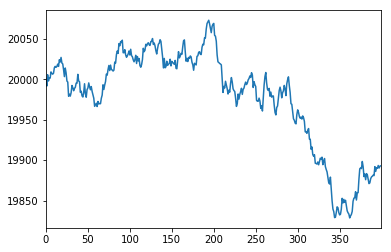

In [5]:
# # Aggregate Y
levels.sum().plot()
plt.show()

In [6]:
# standard deviation of GDP growth

# GDP
Y_levels = levels.sum()

# This is DY(t+1)/Y(t)
lhs = (Y_levels.diff() / Y_levels.shift())#.std()
# This is 
mhs = levels.diff(axis = 1).sum()/levels.sum().shift()

rhs = (sigma * levels.shift(1, axis = 1)*eps).sum()/levels.sum().shift()

rhs2 = (sigma * (levels / levels.sum()).shift(1, axis = 1)*eps).sum()

# (levels / levels.sum()).shift(1, axis = 1) is Sit/Yt. The shift is because otherwise we sould be shifting eps.

In [7]:
# Volatility of GDP
# Eq 3... 
sigma_Y = np.sqrt((sigma**2 * (levels / levels.sum()).shift(1, axis = 1)**2).sum())
sigma_Y2 = sigma * np.sqrt(((levels / levels.sum()).shift(1, axis = 1)**2).sum())

# sigma_Y.plot()
# plt.axhline((Y_levels.diff()/Y_levels.shift()).std())
# plt.show()

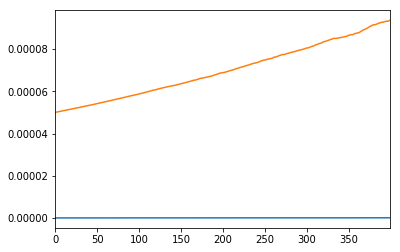

In [8]:
# The passage from 2 to 3 does not seem to hold
shares_i = levels / levels.sum()
x = (shares_i).var()/sigma**2

y = (shares_i**2).sum()

# plt.plot(x, y)
x.plot()
y.plot()

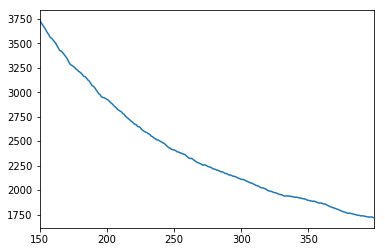

In [9]:
(y/x)[150:].plot()

## Dependence with N

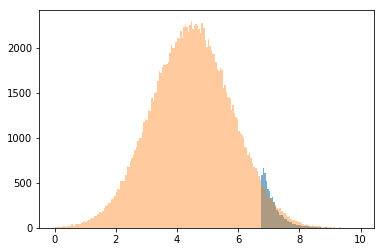

In [10]:
# This is the 'Power law' relation in the upper tail, fitted to empirical observation.
# It has 90% of the value, although only large firms.
# we can see what is the decay, although in our dataset, n is about 6000, no more. 
# Still firm, year grouping can upgrade this x15

bins_ = np.arange(0, 10, .05)

z_0 = -1.1771
value_qs_1 = 6.761

pareto = np.log10(np.random.pareto(-z_0, 6000) + 1 ) + value_qs_1

plt.hist(pareto, bins_, alpha = .6)

mu = 4.47044
sigma = 1.315

advised_size = len(pareto)/(1 - 0.959614)
# (lognormal > min(pareto)).sum() # ~6000 = len(pareto)

lognormal = np.random.normal(mu, sigma, 148566)

plt.hist(lognormal, bins_, alpha = .4)

plt.show()

In [11]:
# What is the decay of GDP volatility with increasing n?

def empirical_pareto_draw(n, z_0 = -1.1771, value_qs_1 = 6.761):
    return np.log10(np.random.pareto(-z_0, n) + 1 ) + value_qs_1

def empirical_lognormal_draw(n, mu = 4.47044, sigma = 1.315):
    return np.random.normal(mu, sigma, n)

def n_corrected_lognormal_draw(n, mu = 4.47044, sigma = 1.315):
    array = np.random.normal(mu, sigma, n)
    return sorted(array)[-round(n*len(pareto)/len(lognormal)):]

# for linear fits
from scipy.optimize import curve_fit
def func(x, a, b):
    return a * x + b

## Test of Gabaix decay proposition

In [19]:
N = np.power(5, np.arange(3, 8.5, .5)).round(-1)
print(N)

df_list = []
zs = [-1.1771, -1, -1.5, -2]
for i, z_0 in enumerate(zs):#, Pareto12]:
    print(z_0)
    s_m_vals = []
    # time steps (T - 1) timesteps for an n x T dataframe
    sigma_N = []
    for n in N:
        print(n)
        n = int(n)

        log_level_0 = pd.DataFrame(empirical_pareto_draw(n, z_0), columns = ['level_0']) 
        
        T = 20
        sigma = 0.3 # Empirical log diff growth
        
        s_m = []
        for m in range(100):  
            #Create the shocks
            eps = pd.DataFrame(np.random.normal(0, sigma, (n, T - 1)), columns = range(1, T))
            log_shocks = np.log10(1 + sigma*eps)
            
            data = pd.DataFrame(pd.concat([log_level_0, log_shocks], axis = 1))
            data.columns = range(T)

            # simulate time evolution
            log_levels = data.cumsum(axis = 1)
            levels= np.power(10, log_levels) # S
            Y_levels = levels.sum() # GDP
            GDP_g = (Y_levels.diff() / Y_levels.shift()) # This is DY(t+1)/Y(t)

            s_m += [GDP_g.std()]

        s_m_vals += [s_m]
    df_list += [pd.DataFrame(s_m_vals, index = 
                  pd.MultiIndex.from_product([[str(z_0)], N], names=['distrib', 'N']))]
    
df = pd.concat(df_list)

result = df.T.describe().T

[1.2000e+02 2.8000e+02 6.2000e+02 1.4000e+03 3.1200e+03 6.9900e+03
 1.5620e+04 3.4940e+04 7.8120e+04 1.7469e+05 3.9062e+05]
-1.1771
120.0
280.0
620.0
1400.0
3120.0
6990.0
15620.0
34940.0
78120.0
174690.0
390620.0
-1
120.0
280.0
620.0
1400.0
3120.0
6990.0
15620.0
34940.0
78120.0
174690.0
390620.0
-1.5
120.0
280.0
620.0
1400.0
3120.0
6990.0
15620.0
34940.0
78120.0
174690.0
390620.0
-2
120.0
280.0
620.0
1400.0
3120.0
6990.0
15620.0
34940.0
78120.0
174690.0
390620.0


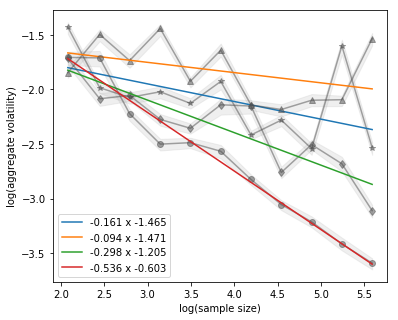

In [21]:
fig, ax = plt.subplots(1, figsize = (6, 5))

for i, distrib in enumerate([str(z_0) for z_0 in zs]):
    r = result.loc[distrib]
    x = np.log10(r.index)
    ax.fill_between(x, np.log10(r['25%']), np.log10(r['75%']), color = '.7', alpha = .2)
    ax.plot(x, np.log10(r['mean']), marker = ['*', '^', 'd', 'o'][i], c = '.3', alpha = .5, label='_')

    popt, pcov = curve_fit(func, x, np.log10(r['mean']))
    ax.plot(x, func(x, *popt), label='%5.3f x %5.3f' % tuple(popt))
    ax.legend()
    
ax.set_xlabel('log(sample size)')
ax.set_ylabel('log(aggregate volatility)')


plt.show()

In [ ]:
# Check:  use log shocks and (1 + e) shocks

## Empirically observed

In [25]:
N = np.power(5, np.arange(3, 8.5, .5)).round(-1)
print(N)

df_list = []
for i, draw_fun in enumerate([empirical_lognormal_draw, empirical_pareto_draw, n_corrected_lognormal_draw]):#, Pareto12]:
    s_m_vals = []
    # time steps (T - 1) timesteps for an n x T dataframe
    sigma_N = []
    for n in N:
        n = int(n)

        log_level_0 = pd.DataFrame(draw_fun(n), columns = ['level_0']) 
        
        T = 20
        sigma = 0.3 # Empirical log diff growth
        
        s_m = []
        for m in range(100):     
            #Create the shocks
            log_shocks = pd.DataFrame(np.random.normal(0, sigma, (n, T - 1)), columns = range(1, T))
#             eps = pd.DataFrame(np.random.normal(0, sigma, (n, T - 1)), columns = range(1, T))
#             log_shocks = np.log10(1 + sigma*eps)
            
            data = pd.DataFrame(pd.concat([log_level_0, log_shocks], axis = 1))
            data.columns = range(T)

            # simulate time evolution
            log_levels = data.cumsum(axis = 1)
            levels= np.power(10, log_levels) # S
            Y_levels = levels.sum() # GDP
            GDP_g = (Y_levels.diff() / Y_levels.shift()) # This is DY(t+1)/Y(t)

            s_m += [GDP_g.std()]

        s_m_vals += [s_m]
    df_list += [pd.DataFrame(s_m_vals, index = 
                  pd.MultiIndex.from_product([[['log_normal', 'pareto', 'lognormal_corr'][i]], N], names=['distrib', 'N']))]
    
df = pd.concat(df_list)

result = df.T.describe().T

[1.2000e+02 2.8000e+02 6.2000e+02 1.4000e+03 3.1200e+03 6.9900e+03
 1.5620e+04 3.4940e+04 7.8120e+04 1.7469e+05 3.9062e+05]


In [45]:
log_shocks = pd.DataFrame(np.random.normal(0, sigma, (n, T - 1)), columns = range(1, T))
log_shocks.head()
log_shocks.head().std(1)

0    0.364394
1    0.315936
2    0.281925
3    0.337365
4    0.356786
dtype: float64

In [47]:
eps = pd.DataFrame(np.random.normal(0, sigma, (n, T - 1)), columns = range(1, T))
log_shocks = np.log10(1 + sigma*eps)
log_shocks.head().std(1)

0    0.032766
1    0.037729
2    0.041698
3    0.038661
4    0.033764
dtype: float64

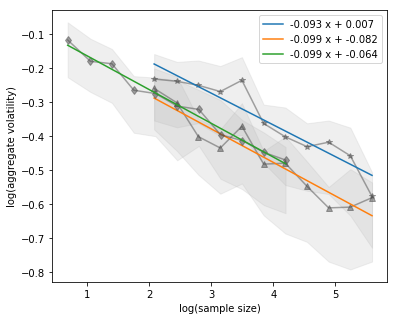

In [27]:
fig, ax = plt.subplots(1, figsize = (6, 5))

for i, distrib in enumerate(['log_normal', 'pareto', 'lognormal_corr']):
    r = result.loc[distrib]
    r.index = r.index/[1, 1, len(lognormal)/len(pareto)][i]
    x = np.log10(r.index)
    ax.fill_between(x, np.log10(r['25%']), np.log10(r['75%']), color = '.7', alpha = .2)
    ax.plot(x, np.log10(r['mean']), marker = ['*', '^', 'd'][i], c = '.3', alpha = .5, label = '_')

    popt, pcov = curve_fit(func, x, np.log10(r['mean']))
    ax.plot(x, func(x, *popt), label='%5.3f x + %5.3f' % tuple(popt))
    ax.legend()
    
ax.set_xlabel('log(sample size)')
ax.set_ylabel('log(aggregate volatility)')


plt.show()

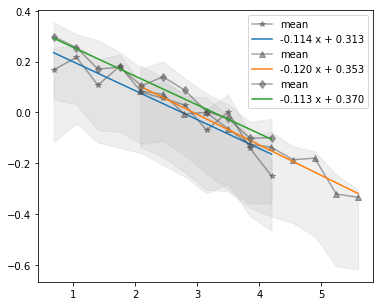

In [24]:
xx

1.9952623149688795

In [ ]:
# initial levels (N)
sigma_N = []
N = np.power(5, np.arange(2, 8, .25)).round(-1)
print(N)
    
result = []
for n in N:
    n = int(n)
    # Lognormal
    Lognormal_0 = pd.DataFrame(random.normal(5, 1, n), columns = ['level_0']) 

    # Normal
    level_0 = pd.DataFrame(random.normal(5000, 1000, n), columns = ['level_0']) 
    Normal_0 = np.log10(level_0)
    
#     # Pareto 3, 2
#     a, m = 1.5, 2.  # shape and mode
#     level_0 = pd.DataFrame((random.pareto(a, n) + 1) * m, columns = ['level_0']) 
#     Pareto12 = np.log10(level_0)
    
#     # Pareto 3, 2
#     a, m = 2.5, 2.  # shape and mode
#     level_0 = pd.DataFrame((random.pareto(a, n) + 1) * m, columns = ['level_0']) 
#     Pareto52 = np.log10(level_0)

#     # Pareto 3, 2
#     a, m = 1.5, 4.  # shape and mode
#     level_0 = pd.DataFrame((random.pareto(a, n) + 1) * m, columns = ['level_0']) 
#     Pareto54 = np.log10(level_0)
    
    sigma_N = []
    for log_level_0 in [Lognormal_0, Normal_0]:#, Pareto12, Pareto52, Pareto54]:
        # time steps (T - 1) timesteps for an n x T dataframe
        T = 150
        sigma = .2
        eps = pd.DataFrame(np.random.normal(0, sigma, (n, T - 1)), columns = range(1, T))
        log_shocks = np.log10(1 + sigma*eps)

        data = pd.DataFrame(pd.concat([log_level_0, log_shocks], axis = 1))
        data.columns = range(T)
        log_levels = data.cumsum(axis = 1)

        # S
        levels= np.power(10, log_levels)

        # GDP
        Y_levels = levels.sum()

        # This is DY(t+1)/Y(t)
        GDP_g = (Y_levels.diff() / Y_levels.shift())#.std() #lhs

        sigma_N += [GDP_g.std()]
    result += [sigma_N]

result = np.array(result).T

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(N, np.array(result[0]), marker = 'o')
plt.plot(N, np.array(result[1]), marker = '*')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(N, np.array(result[0]), marker = 'o')
plt.plot(N, np.array(result[1]), marker = '*')
plt.plot(N, np.array(result[2]), marker = '^')
plt.plot(N, np.array(result[3]), marker = '.')
plt.plot(N, np.array(result[4]), marker = 'd')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [ ]:
    for name in varnames_list:
        res = add_entry(vardict, *name)

    f = open("variables.json","w")
    f.write(json.dumps(res))
    f.close()

## Empirical, actual data

In [ ]:
df = pd.read_csv('./../../data/processed/ID_YM.csv')
df = df.groupby(['ID', 'IMPORT', 'YEAR'])[['VART']].sum().reset_index()

In [ ]:
df_table = df.groupby(['ID', 'IMPORT', 'YEAR'])[['VART']].sum().unstack()
df_table = df_table.loc[df_table.count(1) > 10]

In [ ]:
sigma_N = []
N = np.power(5, np.arange(2.25, 6, .25)).round(-1)
print(N)
s_m_vals = []
result = []
for i in [0, 1]:# Exports, Imports

    df_table_i = df_table.loc[df_table.index.get_level_values(1) == 0]
    df_table_i = df_table_i.interpolate(axis = 1)
    sigma_N = []
    for n in N:
        n = int(n)

        s_m = []
        for m in range(100):
#             if n > 1000: m = 20 # nonsense
            levels = df_table_i.sample(n, replace = True)
            # GDP
            Y_levels = levels.sum()
            # This is DY(t+1)/Y(t)
            GDP_g = (Y_levels.diff() / Y_levels.shift())#.std() #lhs
            s_m += [GDP_g.std()]

        s_m = np.array(s_m)
        s_m_vals += [s_m]
#         print(np.quantile(s_m, .25), np.mean(s_m), np.quantile(s_m, .75))
        sigma_N += [np.mean(s_m)]
    result += [sigma_N]

result = np.array(result) #.T

In [ ]:
plt.plot(N, np.array(result[0]), marker = 'o')
plt.plot(N, np.array(result[1]), marker = '*')
plt.xscale('log')
plt.yscale('log')

plt.axvline(len(df_table_i), c = 'k')

plt.show()

In [ ]:
plt.plot(N, np.array(result[0]), marker = 'o')
plt.plot(N, np.array(result[1]), marker = '*')
plt.xscale('log')
plt.yscale('log')

plt.axvline(len(df_table_i), c = 'k')
plt.plot([10,10000],[.5,.05], c = 'k')

plt.show()

In [ ]:
fig, ax = plt.subplots(1, figsize = (12, 6))
pd.DataFrame(np.array(s_m_vals)).T.describe().T[['mean','min','25%','50%','75%','max']].plot(marker = '.', ax = ax)
# plt.xscale('log')
ax.set_yscale('log')
plt.show()